# Data Analysis 4: Causal Analysis 2nd Assignment
## Author: Márton Nagy

In this assignment, I will try to uncover to what extent economic activity cause CO2 emissions.

First, let's import the needed packages.

In [2]:
import pandas as pd
import numpy as np
import math
from plotnine import *
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
%matplotlib inline
from stargazer.stargazer import Stargazer

import warnings
warnings.filterwarnings("ignore")

## Part 1: Data import and cleaning

Importing the dataset, as it was downloaded from the World Bank's [website](https://databank.worldbank.org/source/world-development-indicators).

In [130]:
raw_df = pd.read_excel('WDI_data_DA4.xlsx')

In [132]:
raw_df.columns = ['c', 'c_code', 's', 's_code'] + list(range(1992,2024))

Dropping the footnotes and unnecessary columns.

In [134]:
raw_df = raw_df[raw_df['c_code'].notna()]

In [136]:
raw_df.drop(columns=['c', 's_code'], inplace = True)

In [137]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1519 entries, 0 to 1518
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c_code  1519 non-null   object 
 1   s       1519 non-null   object 
 2   1992    1302 non-null   float64
 3   1993    1304 non-null   float64
 4   1994    1311 non-null   float64
 5   1995    1335 non-null   float64
 6   1996    1338 non-null   float64
 7   1997    1343 non-null   float64
 8   1998    1344 non-null   float64
 9   1999    1345 non-null   float64
 10  2000    1358 non-null   float64
 11  2001    1358 non-null   float64
 12  2002    1361 non-null   float64
 13  2003    1364 non-null   float64
 14  2004    1394 non-null   float64
 15  2005    1395 non-null   float64
 16  2006    1400 non-null   float64
 17  2007    1401 non-null   float64
 18  2008    1378 non-null   float64
 19  2009    1380 non-null   float64
 20  2010    1382 non-null   float64
 21  2011    1385 non-null   float64
 22  2012 

The dataset is in a wide format, which is not ideal for analysis. So, I transform it to a long, tidy format, where each row is a country-year observation, and the columns are the different variables.

In [158]:
df_long = raw_df.melt(id_vars=['c_code', 's'], var_name='year', value_name='value')

In [160]:
df_long = df_long.pivot(index=['c_code', 'year'], columns='s', values='value').reset_index()

Some remarks about the variables:

- my outcome variable is *Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)*, which will be later transformed to a tons per capita measure;
- my causal variable is *GDP per capita, PPP (constant 2021 international \$)*;
- I have identified 4 possible confounder variables:
  - energy intensity of the economy (*Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)*): as an economy gets more energy intense, it might have both a higher GDP and higher CO2 emissions;
  - sectoral composition of the economy (*Industry (including construction), value added (% of GDP)*): industrialization of a country might entail higher GDP and higher emissions;
  - renewable energy share in energy output (*Renewable electricity output (% of total electricity output)*): higher use renewable sources might entail lower emissions, but higher GDP (as more developed economies turn towerds renewables);
  - urbanization (*Urban population (% of total population)*): as more and more people move to the cities, emissions may get lower (as people need to commute much less), but GDP may grow (as people perform higher value added jobs in large cities).

As for the outcome, note that it only measures CO2 emissions, rather than total greenhouse gas emissions, so it is an imperfect measure of GHG emissions. I have chosen this variable rather than total GHG emissions in CO2 equivalent units, as the task description explicitly asked for this. LULUCF means land use, land-use change and forestry. I have not found such a variable that would include LULUCF in CO2 emissions, thus I have went with excluding this.

In [162]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944 entries, 0 to 6943
Data columns (total 9 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   c_code                                                                6944 non-null   object 
 1   year                                                                  6944 non-null   int64  
 2   Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)     6496 non-null   float64
 3   Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)  3192 non-null   float64
 4   GDP per capita, PPP (constant 2021 international $)                   6216 non-null   float64
 5   Industry (including construction), value added (% of GDP)             5921 non-null   float64
 6   Population, total                                                     6944 non-null   float64
 7 

In [164]:
((1-df_long.isna().sum()/df_long.shape[0])*100).round(2)

s
c_code                                                                  100.00
year                                                                    100.00
Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)        93.55
Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)     45.97
GDP per capita, PPP (constant 2021 international $)                      89.52
Industry (including construction), value added (% of GDP)                85.27
Population, total                                                       100.00
Renewable electricity output (% of total electricity output)             75.06
Urban population (% of total population)                                 99.08
dtype: float64

In [146]:
df_long.columns = ['c_code', 'year', 'co2_total', 'energ_intensity', 'gdp_pc_ppp', 'industry_gdp_pct', 'pop',
                   'renew_energ_pct', 'urban_pop_pct']

I calculate the share of missing values per country per feature.

In [148]:
missing_data = (df_long.iloc[:, 2:].isna().groupby(df_long['c_code']).mean() * 100).reset_index()

In [150]:
missing_data

,c_code,co2_total,energ_intensity,gdp_pc_ppp,industry_gdp_pct,pop,renew_energ_pct,urban_pop_pct
0,ABW,0.0,100.000,0.0,21.875,0.0,25.0,0.0
1,AFG,0.0,100.000,25.0,31.250,0.0,25.0,0.0
2,AGO,0.0,28.125,0.0,9.375,0.0,25.0,0.0
3,ALB,0.0,28.125,0.0,12.500,0.0,25.0,0.0
4,AND,100.0,100.000,0.0,25.000,0.0,25.0,0.0
...,...,...,...,...,...,...,...,...
212,XKX,100.0,78.125,50.0,50.000,0.0,25.0,100.0
213,YEM,0.0,100.000,100.0,15.625,0.0,25.0,0.0
214,ZAF,0.0,28.125,0.0,0.000,0.0,25.0,0.0
215,ZMB,0.0,31.250,0.0,0.000,0.0,25.0,0.0


I filter out countries for which we do not have complete coverage of the 1992-2023 time period in our outcome and causal variables. This means dropping 37 countries out of the 217.

In [20]:
main_vars_missing = list(missing_data[(missing_data['gdp_pc_ppp'] > 0) | (missing_data['co2_total'] > 0)]['c_code'].values)

In [21]:
main_vars_missing

['AFG',
 'AND',
 'ASM',
 'BTN',
 'CHI',
 'CUB',
 'CUW',
 'CYM',
 'DJI',
 'ERI',
 'FRO',
 'GIB',
 'GRL',
 'GUM',
 'IMN',
 'LBN',
 'LIE',
 'MAF',
 'MCO',
 'MNE',
 'MNP',
 'NCL',
 'PRK',
 'PSE',
 'PYF',
 'SMR',
 'SRB',
 'SSD',
 'SXM',
 'SYR',
 'TCA',
 'TON',
 'VEN',
 'VGB',
 'VIR',
 'XKX',
 'YEM']

In [22]:
df_long = df_long[~df_long['c_code'].isin(main_vars_missing)]

As we can see, we still have some missing values in some of our possible confounders, except for the urban population percentage. For simplicity, I decided to work further with this variable so that I do not have to drop more observations.

I also examined the sectora composition variable, but it turned out that around a 100 countries were affected by missing values, so I deemed that is not quite usable.

In [24]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5760 entries, 0 to 6943
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   c_code            5760 non-null   object 
 1   year              5760 non-null   int64  
 2   co2_total         5760 non-null   float64
 3   energ_intensity   3086 non-null   float64
 4   gdp_pc_ppp        5760 non-null   float64
 5   industry_gdp_pct  5330 non-null   float64
 6   pop               5760 non-null   float64
 7   renew_energ_pct   4324 non-null   float64
 8   urban_pop_pct     5760 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 450.0+ KB


Transforming the CO2 emissions to tons per capita and filtering for relevant columns.

In [60]:
df_long['co2_pc'] = df_long['co2_total'] / df_long['pop'] * 1_000_000

In [62]:
df_work = df_long[['c_code', 'year', 'gdp_pc_ppp', 'co2_pc', 'urban_pop_pct', 'pop']]

In [64]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5760 entries, 0 to 6943
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   c_code         5760 non-null   object 
 1   year           5760 non-null   int64  
 2   gdp_pc_ppp     5760 non-null   float64
 3   co2_pc         5760 non-null   float64
 4   urban_pop_pct  5760 non-null   float64
 5   pop            5760 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 315.0+ KB


Simple descriptive statistics already suggest that both the outcome and the causal variable is quite skewed - but let's examine this as graphically as well.

In [67]:
df_work.iloc[:, 2:].describe(percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T.round(2)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
gdp_pc_ppp,5760.0,21396.69,2.400937e+04,510.82,1492.49,2172.29,4160.62,12422.74,31101.79,54267.94,6.646113e+04,1.743391e+05
co2_pc,5760.0,5.12,9.900000e+00,0.00,0.06,0.13,0.56,2.30,6.54,11.36,1.813000e+01,2.028700e+02
urban_pop_pct,5760.0,56.17,2.344000e+01,6.29,18.38,23.59,36.53,56.21,74.64,87.42,9.416000e+01,1.000000e+02
pop,5760.0,36683460.59,1.366708e+08,9038.00,90316.70,248832.60,1889740.25,7107269.50,23463598.00,67459866.60,1.272020e+08,1.438070e+09


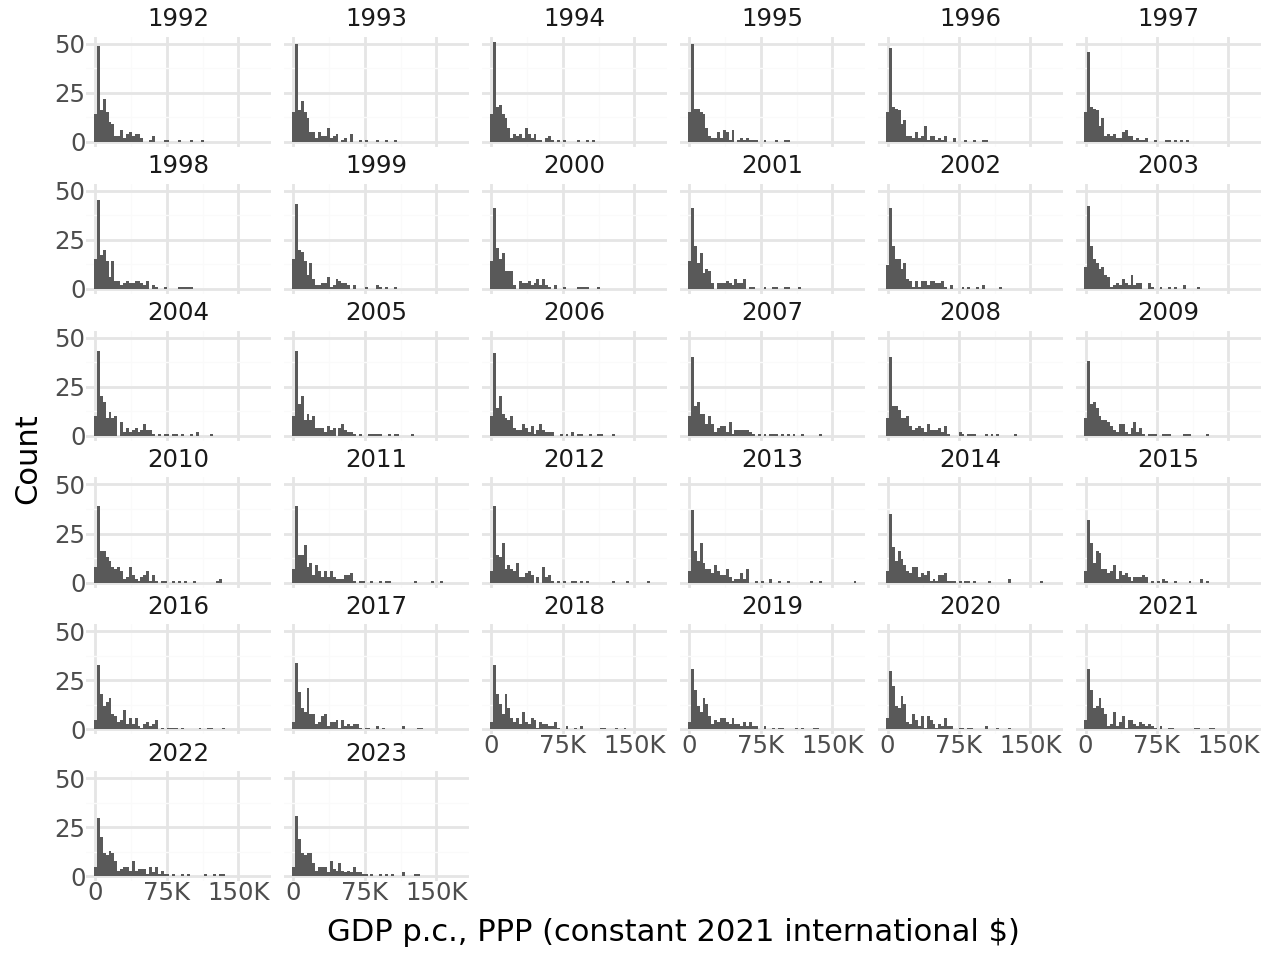

In [69]:
(
    ggplot(df_work, aes('gdp_pc_ppp'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    + scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 75_000, 150_000], labels = ['0', '75K', '150K'])
    + labs(x = 'GDP p.c., PPP (constant 2021 international $)', y = 'Count')
)

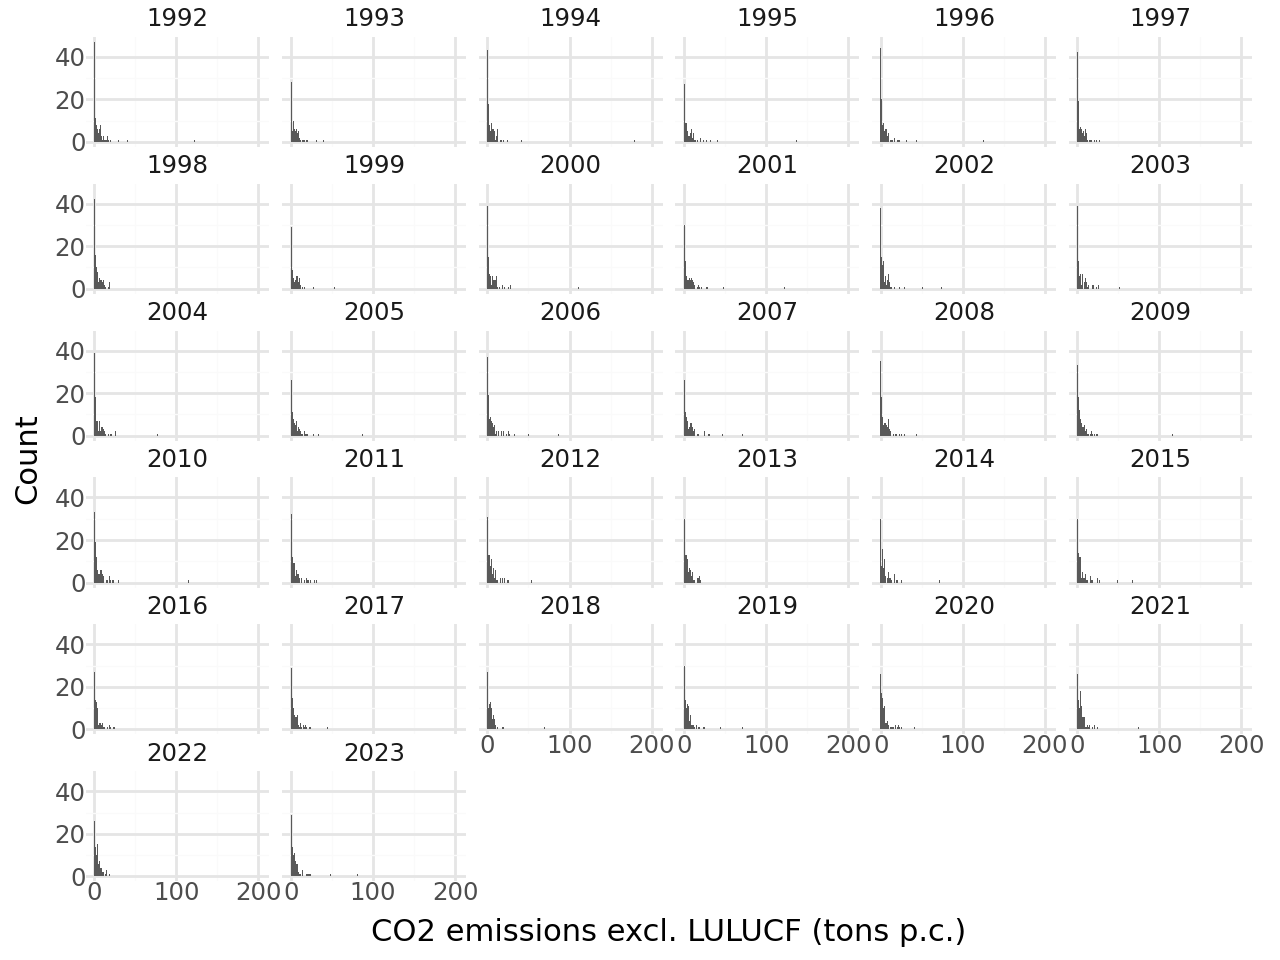

In [70]:
(
    ggplot(df_work, aes('co2_pc'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    + scale_y_continuous(breaks = [0, 20, 40])
    + scale_x_continuous(breaks = [0, 100, 200])
    + labs(x = 'CO2 emissions excl. LULUCF (tons p.c.)', y = 'Count')
)

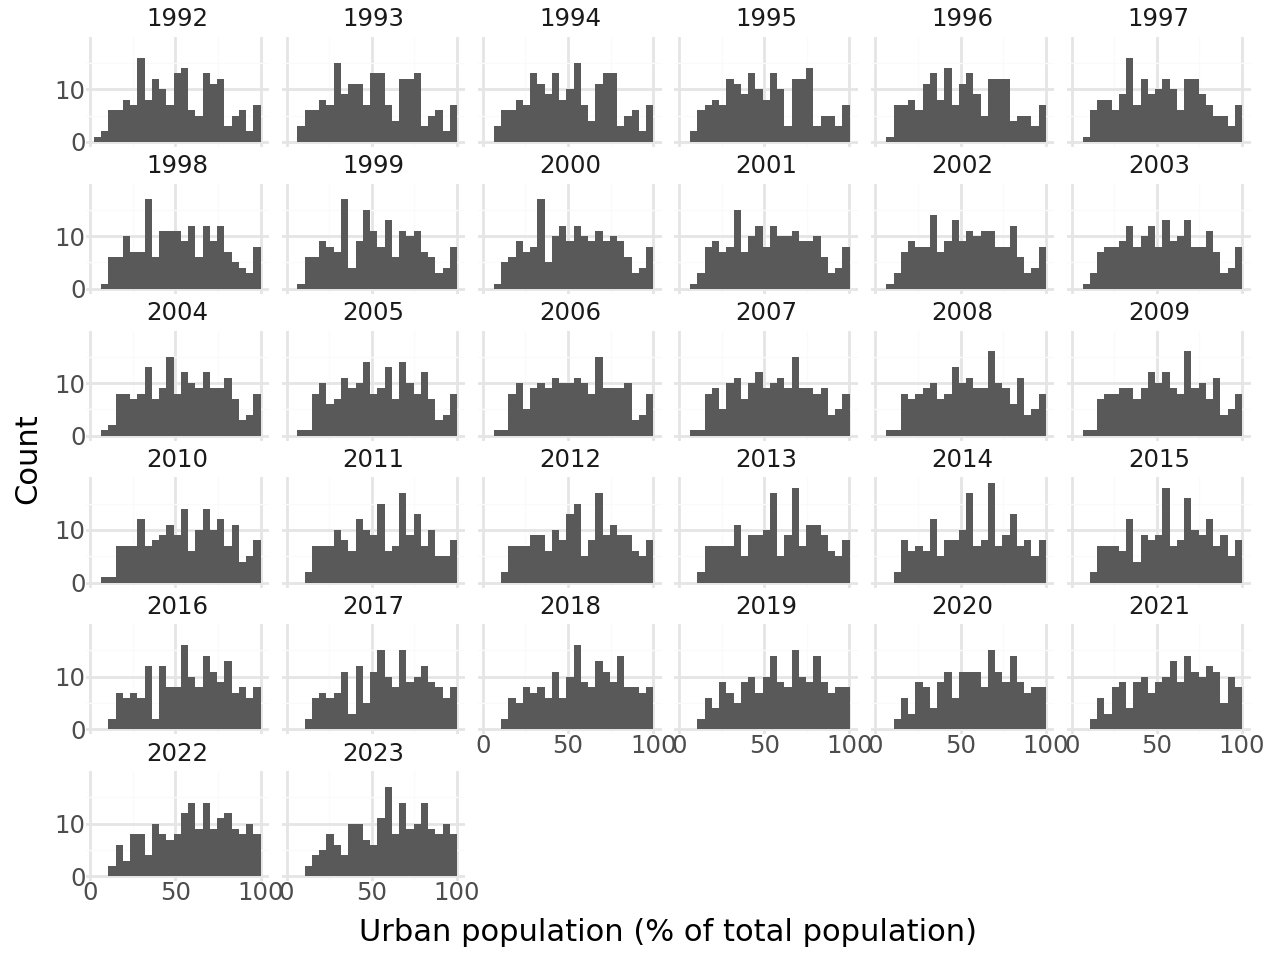

In [71]:
(
    ggplot(df_work, aes('urban_pop_pct'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    + scale_y_continuous(breaks = [0, 10, 20])
    + scale_x_continuous(breaks = [0, 50, 100])
    + labs(x = 'Urban population (% of total population)', y = 'Count')
)

Because of the skewed distributions, let's transform the outcome and the causal variables logarithmically. I leave the confounder unchanged (as it is already a percentage, and has a relatively normal distribution).

As the CO2 emissions per capita had some zero values, I set these values to the half of the minimum value of CO2 emissions per capita before taking the log. This affected only 120 observations out of the 5760, so it should not influence my results substantially.

In [73]:
df_work['ln_gdp_pc_ppp'] = np.log(df_work['gdp_pc_ppp'])
df_work['ln_co2_pc'] = df_work['co2_pc'].apply(lambda x: np.log(df_work[df_work['co2_pc'] > 0]['co2_pc'].min()*0.5) if x == 0 else np.log(x))
df_work['co2_zero_flag'] = df_work['co2_pc'].apply(lambda x: 1 if x == 0 else 0)

In [74]:
df_work.co2_zero_flag.sum()

120

In [75]:
df_work.shape[0]

5760

In [76]:
df_work.iloc[:, 2:].describe(percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T.round(2)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
gdp_pc_ppp,5760.0,21396.69,2.400937e+04,510.82,1492.49,2172.29,4160.62,12422.74,31101.79,54267.94,6.646113e+04,1.743391e+05
co2_pc,5760.0,5.12,9.900000e+00,0.00,0.06,0.13,0.56,2.30,6.54,11.36,1.813000e+01,2.028700e+02
urban_pop_pct,5760.0,56.17,2.344000e+01,6.29,18.38,23.59,36.53,56.21,74.64,87.42,9.416000e+01,1.000000e+02
pop,5760.0,36683460.59,1.366708e+08,9038.00,90316.70,248832.60,1889740.25,7107269.50,23463598.00,67459866.60,1.272020e+08,1.438070e+09
ln_gdp_pc_ppp,5760.0,9.33,1.210000e+00,6.24,7.31,7.68,8.33,9.43,10.35,10.90,1.110000e+01,1.207000e+01
ln_co2_pc,5760.0,0.44,1.970000e+00,-6.95,-2.81,-2.05,-0.58,0.83,1.88,2.43,2.900000e+00,5.310000e+00
co2_zero_flag,5760.0,0.02,1.400000e-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,1.000000e+00


Now let's look at the distribution of the log-transformed variables as well.

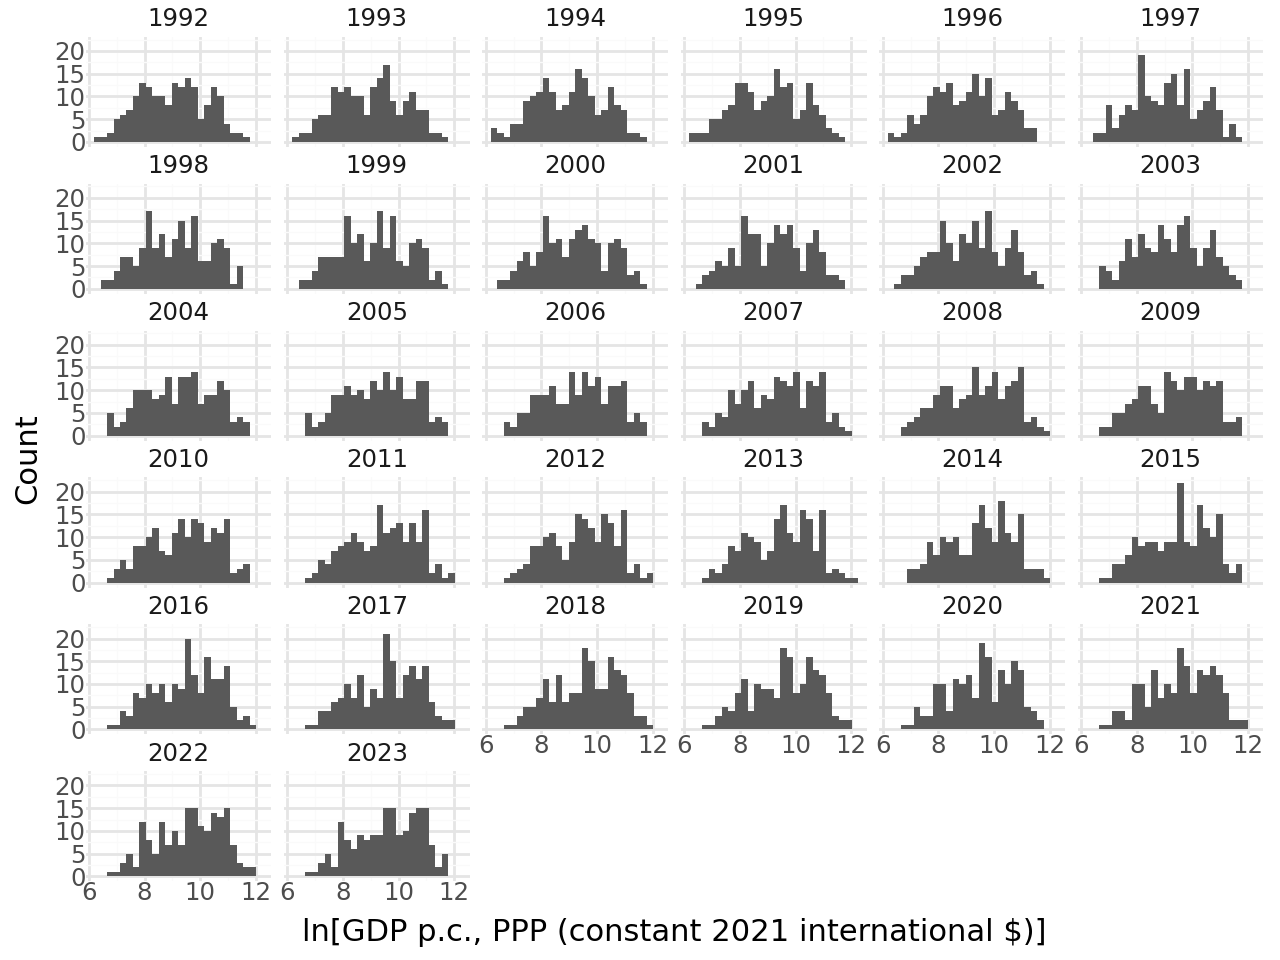

In [79]:
(
    ggplot(df_work, aes('ln_gdp_pc_ppp'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    + scale_y_continuous()
    + scale_x_continuous()
    + labs(x = 'ln[GDP p.c., PPP (constant 2021 international $)]', y = 'Count')
)

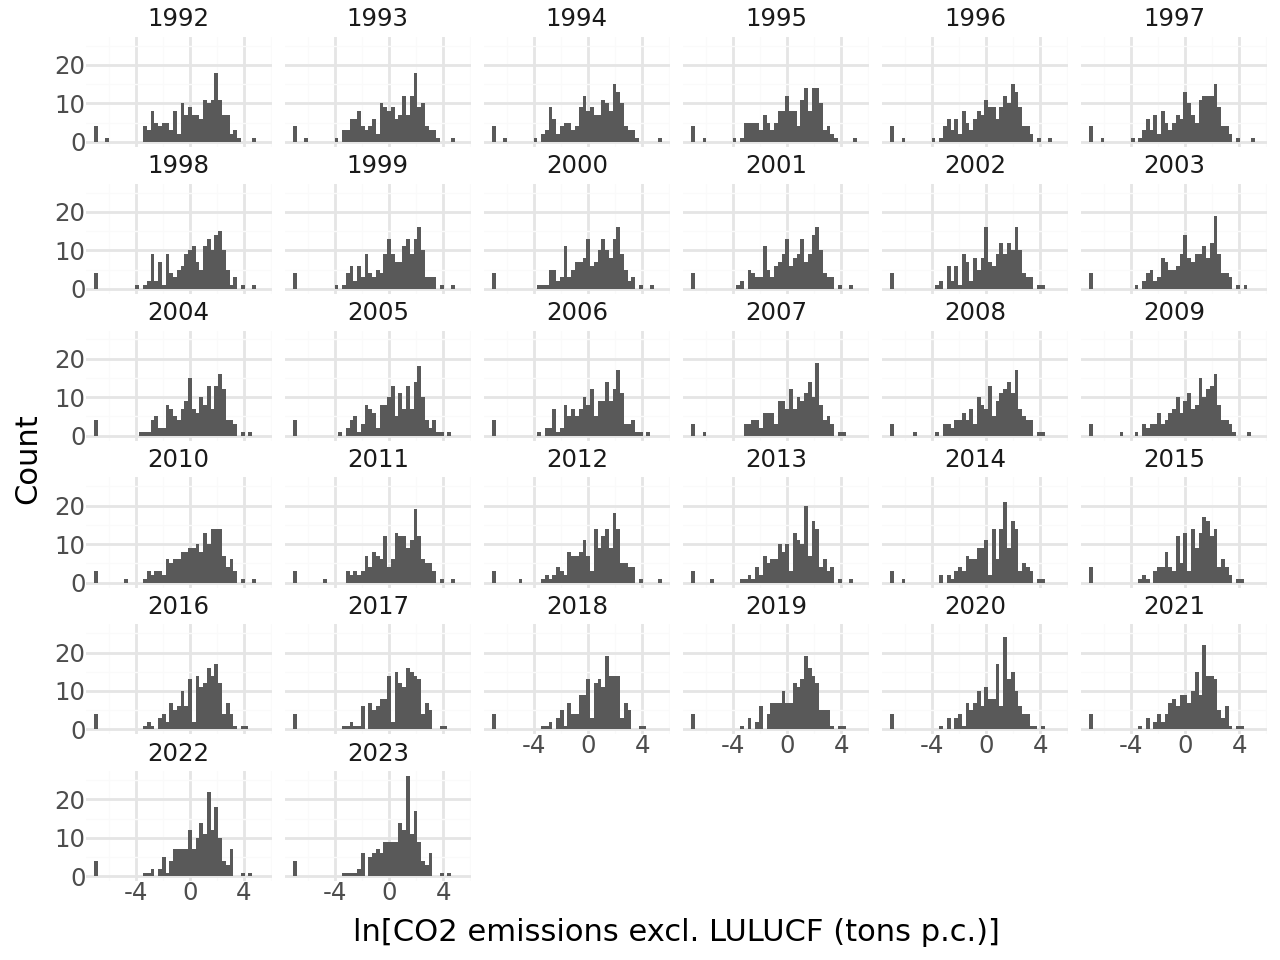

In [80]:
(
    ggplot(df_work, aes('ln_co2_pc'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    + scale_y_continuous()
    + scale_x_continuous()
    + labs(x = 'ln[CO2 emissions excl. LULUCF (tons p.c.)]', y = 'Count')
)

Adding log differences and lagged variables.

In [81]:
df_work['d_ln_gdp_pc_ppp'] = df_work.groupby('c_code')['ln_gdp_pc_ppp'].transform('diff')
df_work['d_ln_co2_pc'] = df_work.groupby('c_code')['ln_co2_pc'].transform('diff')
df_work['d_urban_pop_pct'] = df_work.groupby('c_code')['urban_pop_pct'].transform('diff')

df_work['d2_ln_gdp_pc_ppp'] = df_work.groupby('c_code')['d_ln_gdp_pc_ppp'].transform('diff')
df_work['d2_urban_pop_pct'] = df_work.groupby('c_code')['d_urban_pop_pct'].transform('diff')

In [82]:
lag_ranges = {
    'd_ln_gdp_pc_ppp': range(1, 7),
    'd2_ln_gdp_pc_ppp': range(1, 6),
    'd_urban_pop_pct': range(1, 7),
    'd2_urban_pop_pct': range(1, 6)
}

for col, lags in lag_ranges.items():
    for lag in lags:
        df_work[f'{col}_l{lag}'] = df_work.groupby('c_code')[col].shift(lag)


Now let's estimate the required 6 models, and their versions with the confounder added, plus with cumulative effects where possible. I first estimate all models weighted by population.

Simple OLS for 2005:

In [83]:
m1_data = df_work[df_work['year'] == 2005]
m1 = smf.wls('ln_co2_pc ~ ln_gdp_pc_ppp', data = m1_data, weights = m1_data['pop']).fit(cov_type = 'HC1')

Simple OLS for 2005, with confounder added:

In [85]:
m1_c = smf.wls('ln_co2_pc ~ ln_gdp_pc_ppp + urban_pop_pct', data = m1_data, weights = m1_data['pop']).fit(cov_type = 'HC1')

Simple OLS for 2023:

In [86]:
m2_data = df_work[df_work['year'] == 2023]
m2 = smf.wls('ln_co2_pc ~ ln_gdp_pc_ppp', data = m2_data, weights = m2_data['pop']).fit(cov_type = 'HC1')

FD model with time trend:

In [87]:
df_work['f_year'] = df_work['year'].astype('category')

In [88]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + f_year', df_work, weights = df_work['pop'])
m3 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FD model with time trend and 2 lags:

In [89]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + d_ln_gdp_pc_ppp_l1 + d_ln_gdp_pc_ppp_l2 + f_year', df_work, weights = df_work['pop'])
m4 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FD model with time trend and 2 lags (cumulative effect):

In [90]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp_l2 + d2_ln_gdp_pc_ppp + d2_ln_gdp_pc_ppp_l1 + f_year', df_work, weights = df_work['pop'])
m4_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FD model with time trend and 2 lags, confounder added:

In [91]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + d_ln_gdp_pc_ppp_l1 + d_ln_gdp_pc_ppp_l2 + d_urban_pop_pct +\
d_urban_pop_pct_l1 + d_urban_pop_pct_l2 + f_year', df_work, weights = df_work['pop'])
m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FD model with time trend and 2 lags, confounder added (cumulative effect):

In [92]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp_l2 + d2_ln_gdp_pc_ppp + d2_ln_gdp_pc_ppp_l1 + d_urban_pop_pct +\
d_urban_pop_pct_l1 + d_urban_pop_pct_l2 + f_year', df_work, weights = df_work['pop'])
m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FD model with time trend and 6 lags:

In [93]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + d_ln_gdp_pc_ppp_l1 + d_ln_gdp_pc_ppp_l2 + d_ln_gdp_pc_ppp_l3 + \
    d_ln_gdp_pc_ppp_l4 + d_ln_gdp_pc_ppp_l5 + d_ln_gdp_pc_ppp_l6 + f_year', df_work, weights = df_work['pop'])
m5 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FD model with time trend and 6 lags (cumulative effects):

In [94]:
m = smf.wls('d_ln_co2_pc ~ d_ln_gdp_pc_ppp_l6 + d2_ln_gdp_pc_ppp + d2_ln_gdp_pc_ppp_l1 + d2_ln_gdp_pc_ppp_l2 + d2_ln_gdp_pc_ppp_l3 + \
    d2_ln_gdp_pc_ppp_l4 + d2_ln_gdp_pc_ppp_l5 + f_year', df_work, weights = df_work['pop'])
m5_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)

FE model with country and year fixed effects:

In [95]:
m6_data = df_work.set_index(['c_code', 'year'])

In [96]:
m6 = PanelOLS.from_formula('ln_co2_pc ~ ln_gdp_pc_ppp + f_year + EntityEffects',
                           m6_data, weights = df_work['pop']).fit(cov_type="clustered", cluster_entity=True)

FE model with country and year fixed effects, confounder added:

In [98]:
m6_c = PanelOLS.from_formula('ln_co2_pc ~ ln_gdp_pc_ppp + urban_pop_pct + f_year + EntityEffects',
                             m6_data, weights = df_work['pop']).fit(cov_type="clustered", cluster_entity=True)

Now let's put all models with only the relevant coefficients into a nicer Stargazer table.

In [99]:
models = [m1, m1_c, m2, m3, m4, m4_c, m4_cumul, m4_c_cumul, m5, m5_cumul, m6, m6_c]
sg = Stargazer(models)
sg.custom_columns(['OLS (2005)', 'OLS (2005, contr.)', 'OLS (2023)', 'FD panel', 'PD panel (2 lags)', 'FD panel (2 lags, contr.)',
                  'FD panel (2 lags, cumul.)', 'FD panel (2 lags, cumul., contr.)', 'FD panel (6 lags)', 'FD panel (6 lags, cumul.)',
                  'FE', 'FE (contr.)'])
sg.covariate_order(['ln_gdp_pc_ppp', 'd_ln_gdp_pc_ppp', 'd_ln_gdp_pc_ppp_l1', 'd_ln_gdp_pc_ppp_l2', 'd_ln_gdp_pc_ppp_l3',
                   'd_ln_gdp_pc_ppp_l4', 'd_ln_gdp_pc_ppp_l5', 'd_ln_gdp_pc_ppp_l6',
                    'urban_pop_pct', 'd_urban_pop_pct', 'd_urban_pop_pct_l1', 'd_urban_pop_pct_l2', 'Intercept'])
sg.add_custom_notes(['All models are weighted by population. Robust SEs used (HC1 for cross-sectional models, clustered for panel models).'])

In [105]:
sg

I reestimate all models without the weights as well.

In [106]:
o_m1 = smf.ols('ln_co2_pc ~ ln_gdp_pc_ppp', data = m1_data).fit(cov_type = 'HC1')
o_m1_c = smf.ols('ln_co2_pc ~ ln_gdp_pc_ppp + urban_pop_pct', data = m1_data).fit(cov_type = 'HC1')
o_m2 = smf.ols('ln_co2_pc ~ ln_gdp_pc_ppp', data = m2_data).fit(cov_type = 'HC1')
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + f_year', df_work)
o_m3 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + d_ln_gdp_pc_ppp_l1 + d_ln_gdp_pc_ppp_l2 + f_year', df_work)
o_m4 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp_l2 + d2_ln_gdp_pc_ppp + d2_ln_gdp_pc_ppp_l1 + f_year', df_work)
o_m4_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + d_ln_gdp_pc_ppp_l1 + d_ln_gdp_pc_ppp_l2 + d_urban_pop_pct +\
d_urban_pop_pct_l1 + d_urban_pop_pct_l2 + f_year', df_work)
o_m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp_l2 + d2_ln_gdp_pc_ppp + d2_ln_gdp_pc_ppp_l1 + d_urban_pop_pct +\
d_urban_pop_pct_l1 + d_urban_pop_pct_l2 + f_year', df_work)
o_m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp + d_ln_gdp_pc_ppp_l1 + d_ln_gdp_pc_ppp_l2 + d_ln_gdp_pc_ppp_l3 + \
    d_ln_gdp_pc_ppp_l4 + d_ln_gdp_pc_ppp_l5 + d_ln_gdp_pc_ppp_l6 + f_year', df_work)
o_m5 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
m = smf.ols('d_ln_co2_pc ~ d_ln_gdp_pc_ppp_l6 + d2_ln_gdp_pc_ppp + d2_ln_gdp_pc_ppp_l1 + d2_ln_gdp_pc_ppp_l2 + d2_ln_gdp_pc_ppp_l3 + \
    d2_ln_gdp_pc_ppp_l4 + d2_ln_gdp_pc_ppp_l5 + f_year', df_work)
o_m5_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_work.loc[m.data.row_labels, "c_code"]},
)
o_m6 = PanelOLS.from_formula('ln_co2_pc ~ ln_gdp_pc_ppp + f_year + EntityEffects',
                           m6_data).fit(cov_type="clustered", cluster_entity=True)
o_m6_c = PanelOLS.from_formula('ln_co2_pc ~ ln_gdp_pc_ppp + urban_pop_pct + f_year + EntityEffects',
                             m6_data).fit(cov_type="clustered", cluster_entity=True)					   

In [108]:
o_models = [o_m1, o_m1_c, o_m2, o_m3, o_m4, o_m4_c, o_m4_cumul, o_m4_c_cumul, o_m5, o_m5_cumul, o_m6, o_m6_c]
o_sg = Stargazer(o_models)
o_sg.custom_columns(['OLS (2005)', 'OLS (2005, contr.)', 'OLS (2023)', 'FD panel', 'PD panel (2 lags)', 'FD panel (2 lags, contr.)',
                  'FD panel (2 lags, cumul.)', 'FD panel (2 lags, cumul., contr.)', 'FD panel (6 lags)', 'FD panel (6 lags, cumul.)',
                  'FE', 'FE (contr.)'])
o_sg.covariate_order(['ln_gdp_pc_ppp', 'd_ln_gdp_pc_ppp', 'd_ln_gdp_pc_ppp_l1', 'd_ln_gdp_pc_ppp_l2', 'd_ln_gdp_pc_ppp_l3',
                   'd_ln_gdp_pc_ppp_l4', 'd_ln_gdp_pc_ppp_l5', 'd_ln_gdp_pc_ppp_l6',
                    'urban_pop_pct', 'd_urban_pop_pct', 'd_urban_pop_pct_l1', 'd_urban_pop_pct_l2', 'Intercept'])
o_sg.add_custom_notes(['All models are unweighted. Robust SEs used (HC1 for cross-sectional models, clustered for panel models).'])
o_sg